<a href="https://colab.research.google.com/github/HasanNayon/Anomaly-detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tarfile
tar_file = '/content/drive/MyDrive/new/mvtec_anomaly_detection.tar.xz'
destination = '/content/mvtec_anomaly_detection'

with tarfile.open(tar_file, 'r:*') as tar:
    tar.extractall(path=destination)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from skimage import morphology

## ======================================
## 1. MVTec Data Loader
## ======================================

def load_mvtec_dataset(dataset_path, category='bottle', mode='train', target_size=(256, 256)):
    """
    Load MVTec Anomaly Detection dataset
    Args:
        dataset_path: Path to MVTec root directory
        category: One of ['bottle', 'cable', 'capsule', etc.]
        mode: 'train' or 'test'
        target_size: Resize dimensions
    Returns:
        images: Normal images if mode='train', (images, masks) if mode='test'
    """
    normal_path = os.path.join(dataset_path, category, mode, 'good')
    normal_images = []

    # Load normal images
    for img_name in sorted(os.listdir(normal_path)):
        img_path = os.path.join(normal_path, img_name)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, target_size)
        normal_images.append(img)

    if mode == 'train':
        return tf.stack(normal_images) / 255.0

    # For test mode, load all defect types
    defect_types = [d for d in os.listdir(os.path.join(dataset_path, category, 'test'))
                  if d != 'good']

    test_images = []
    test_masks = []

    for defect in defect_types:
        defect_path = os.path.join(dataset_path, category, 'test', defect)
        mask_path = os.path.join(dataset_path, category, 'ground_truth', defect)

        for img_name in sorted(os.listdir(defect_path)):
            # Load image
            img = tf.io.read_file(os.path.join(defect_path, img_name))
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, target_size)

            # Load mask (if exists)
            mask_name = img_name.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_path, mask_name)):
                mask = tf.io.read_file(os.path.join(mask_path, mask_name))
                mask = tf.image.decode_png(mask, channels=1)
                mask = tf.image.resize(mask, target_size)
                mask = tf.cast(mask > 0, tf.float32)
            else:
                mask = tf.zeros(target_size + (1,), dtype=tf.float32)

            test_images.append(img)
            test_masks.append(mask)

    return (tf.stack(normal_images)/255.0,
            tf.stack(test_images)/255.0,
            tf.stack(test_masks))


In [10]:
## ======================================
## 2. Model Architecture (Modified for MVTec)
## ======================================

def build_mvtec_autoencoder(input_shape=(256, 256, 3)):
    """Autoencoder optimized for MVTec dataset"""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(32, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)

    return models.Model(inputs, outputs)

## ======================================
## 3. Training with MVTec-specific Setup
## ======================================

# Load data
dataset_path = '/content/mvtec_anomaly_detection'  # Update this path
category = 'bottle'  # Change to your category

train_images = load_mvtec_dataset(dataset_path, category, 'train')
test_images, test_masks = load_mvtec_dataset(dataset_path, category, 'test')[1:]

# Split train into train/val
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

# Build and compile model
autoencoder = build_mvtec_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse')

# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    f'mvtec_{category}_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train
history = autoencoder.fit(
    train_images, train_images,
    validation_data=(val_images, val_images),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 55, 147, 109, 108, 142,  25, 125,  16, 172, 191,  69, 101,  67,
       104, 132, 207,  95,  82, 159, 196, 162, 150,  96, 199,  68, 156,
        86, 100,  38,  24, 182, 117,  29,  19, 135, 139,  66,  65,   5,
       146,  56,  97, 128,  79, 204, 178,  31,  12,  35,  28,  42, 115,
        98, 143,  51, 118, 177,  76,  41, 187,  78, 124,  26, 140, 168,
       122,   2,  77,  46, 127, 112,  90,  85, 141,  36, 119,  61,  22,
       138, 111,  33,  11, 203, 166,   6,  27, 170, 200, 144,   4,  32,
       113, 152, 120, 193, 114,  10,  62, 148, 153, 173,   0, 202, 183,
        70, 163,  64,  44, 137,  40, 123,  23, 158, 154,  81,  39, 176,
        47,  94, 161,  43, 145,   3, 105,  53, 133, 189, 164, 194,  49,
        80,  34,   7, 110,  91,  83, 185, 190,  89,   8,  13,  59, 180,
       131,  17,  72, 184, 134, 175, 192,  63,  54, 107,  50, 174, 205,
       169,  58,  48,  88,  21,  57, 160, 201, 129,  37, 157, 197,   1,
        52, 149, 130, 151, 103,  99, 116,  87,  74, 121, 208,  20, 188,
        71, 106,  14,  92, 179, 102])

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from skimage import morphology
from sklearn.model_selection import train_test_split # Import train_test_split

## ======================================
## 1. MVTec Data Loader
## ======================================

def load_mvtec_dataset(dataset_path, category='bottle', mode='train', target_size=(256, 256)):
    """
    Load MVTec Anomaly Detection dataset
    Args:
        dataset_path: Path to MVTec root directory
        category: One of ['bottle', 'cable', 'capsule', etc.]
        mode: 'train' or 'test'
        target_size: Resize dimensions
    Returns:
        images: Normal images if mode='train', (images, masks) if mode='test'
    """
    normal_path = os.path.join(dataset_path, category, mode, 'good')
    normal_images = []

    # Load normal images
    for img_name in sorted(os.listdir(normal_path)):
        img_path = os.path.join(normal_path, img_name)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, target_size)
        normal_images.append(img)

    if mode == 'train':
        return tf.stack(normal_images) / 255.0

    # For test mode, load all defect types
    defect_types = [d for d in os.listdir(os.path.join(dataset_path, category, 'test'))
                  if d != 'good']

    test_images = []
    test_masks = []

    for defect in defect_types:
        defect_path = os.path.join(dataset_path, category, 'test', defect)
        mask_path = os.path.join(dataset_path, category, 'ground_truth', defect)

        for img_name in sorted(os.listdir(defect_path)):
            # Load image
            img = tf.io.read_file(os.path.join(defect_path, img_name))
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, target_size)

            # Load mask (if exists)
            mask_name = img_name.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_path, mask_name)):
                mask = tf.io.read_file(os.path.join(mask_path, mask_name))
                mask = tf.image.decode_png(mask, channels=1)
                mask = tf.image.resize(mask, target_size)
                mask = tf.cast(mask > 0, tf.float32)
            else:
                mask = tf.zeros(target_size + (1,), dtype=tf.float32)

            test_images.append(img)
            test_masks.append(mask)

    return (tf.stack(normal_images)/255.0,
            tf.stack(test_images)/255.0,
            tf.stack(test_masks))

# %%
## ======================================
## 2. Model Architecture (Modified for MVTec)
## ======================================

def build_mvtec_autoencoder(input_shape=(256, 256, 3)):
    """Autoencoder optimized for MVTec dataset"""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(32, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)

    return models.Model(inputs, outputs)

## ======================================
## 3. Training with MVTec-specific Setup
## ======================================

# Load data
dataset_path = '/content/mvtec_anomaly_detection'  # Update this path
category = 'bottle'  # Change to your category

# Load training images and convert to NumPy array
train_images_tf = load_mvtec_dataset(dataset_path, category, 'train')
train_images_np = train_images_tf.numpy() # Convert TensorFlow tensor to NumPy array

# Load test data (no change needed here as it's not split)
_, test_images, test_masks = load_mvtec_dataset(dataset_path, category, 'test')


# Split train into train/val using the NumPy array
train_images, val_images = train_test_split(train_images_np, test_size=0.1, random_state=42)

# Convert the split NumPy arrays back to TensorFlow tensors for training
train_images = tf.convert_to_tensor(train_images)
val_images = tf.convert_to_tensor(val_images)


# Build and compile model
autoencoder = build_mvtec_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse')

# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    f'mvtec_{category}_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train
history = autoencoder.fit(
    train_images, train_images,
    validation_data=(val_images, val_images),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1293   

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 0.1287 - val_loss: 0.1146
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.1101

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - loss: 0.1095 - val_loss: 0.0964
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0867

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 0.0856 - val_loss: 0.0623
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0569

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0564 - val_loss: 0.0463
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0456

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - loss: 0.0454 - val_loss: 0.0424
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0419

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - loss: 0.0418 - val_loss: 0.0399
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0396

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.0395 - val_loss: 0.0386
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0381

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.0381 - val_loss: 0.0369
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0366

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.0365 - val_loss: 0.0351
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0342

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - loss: 0.0340 - val_loss: 0.0279
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0244

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - loss: 0.0241 - val_loss: 0.0154
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0137

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0134 - val_loss: 0.0075
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0071

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0048

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0035

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0031

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 18/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0031

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 19/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0029

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 20/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0028

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0028 - val_loss: 0.0027


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Image-Level AUROC: nan
Pixel-Level AUROC: 0.7301
PRO Score: 0.0942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


<ipython-input-16-2f694cf17a39>:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pro_score = np.trapz(overlaps_at_thresholds, thresholds) / (thresholds[-1] - thresholds[0])


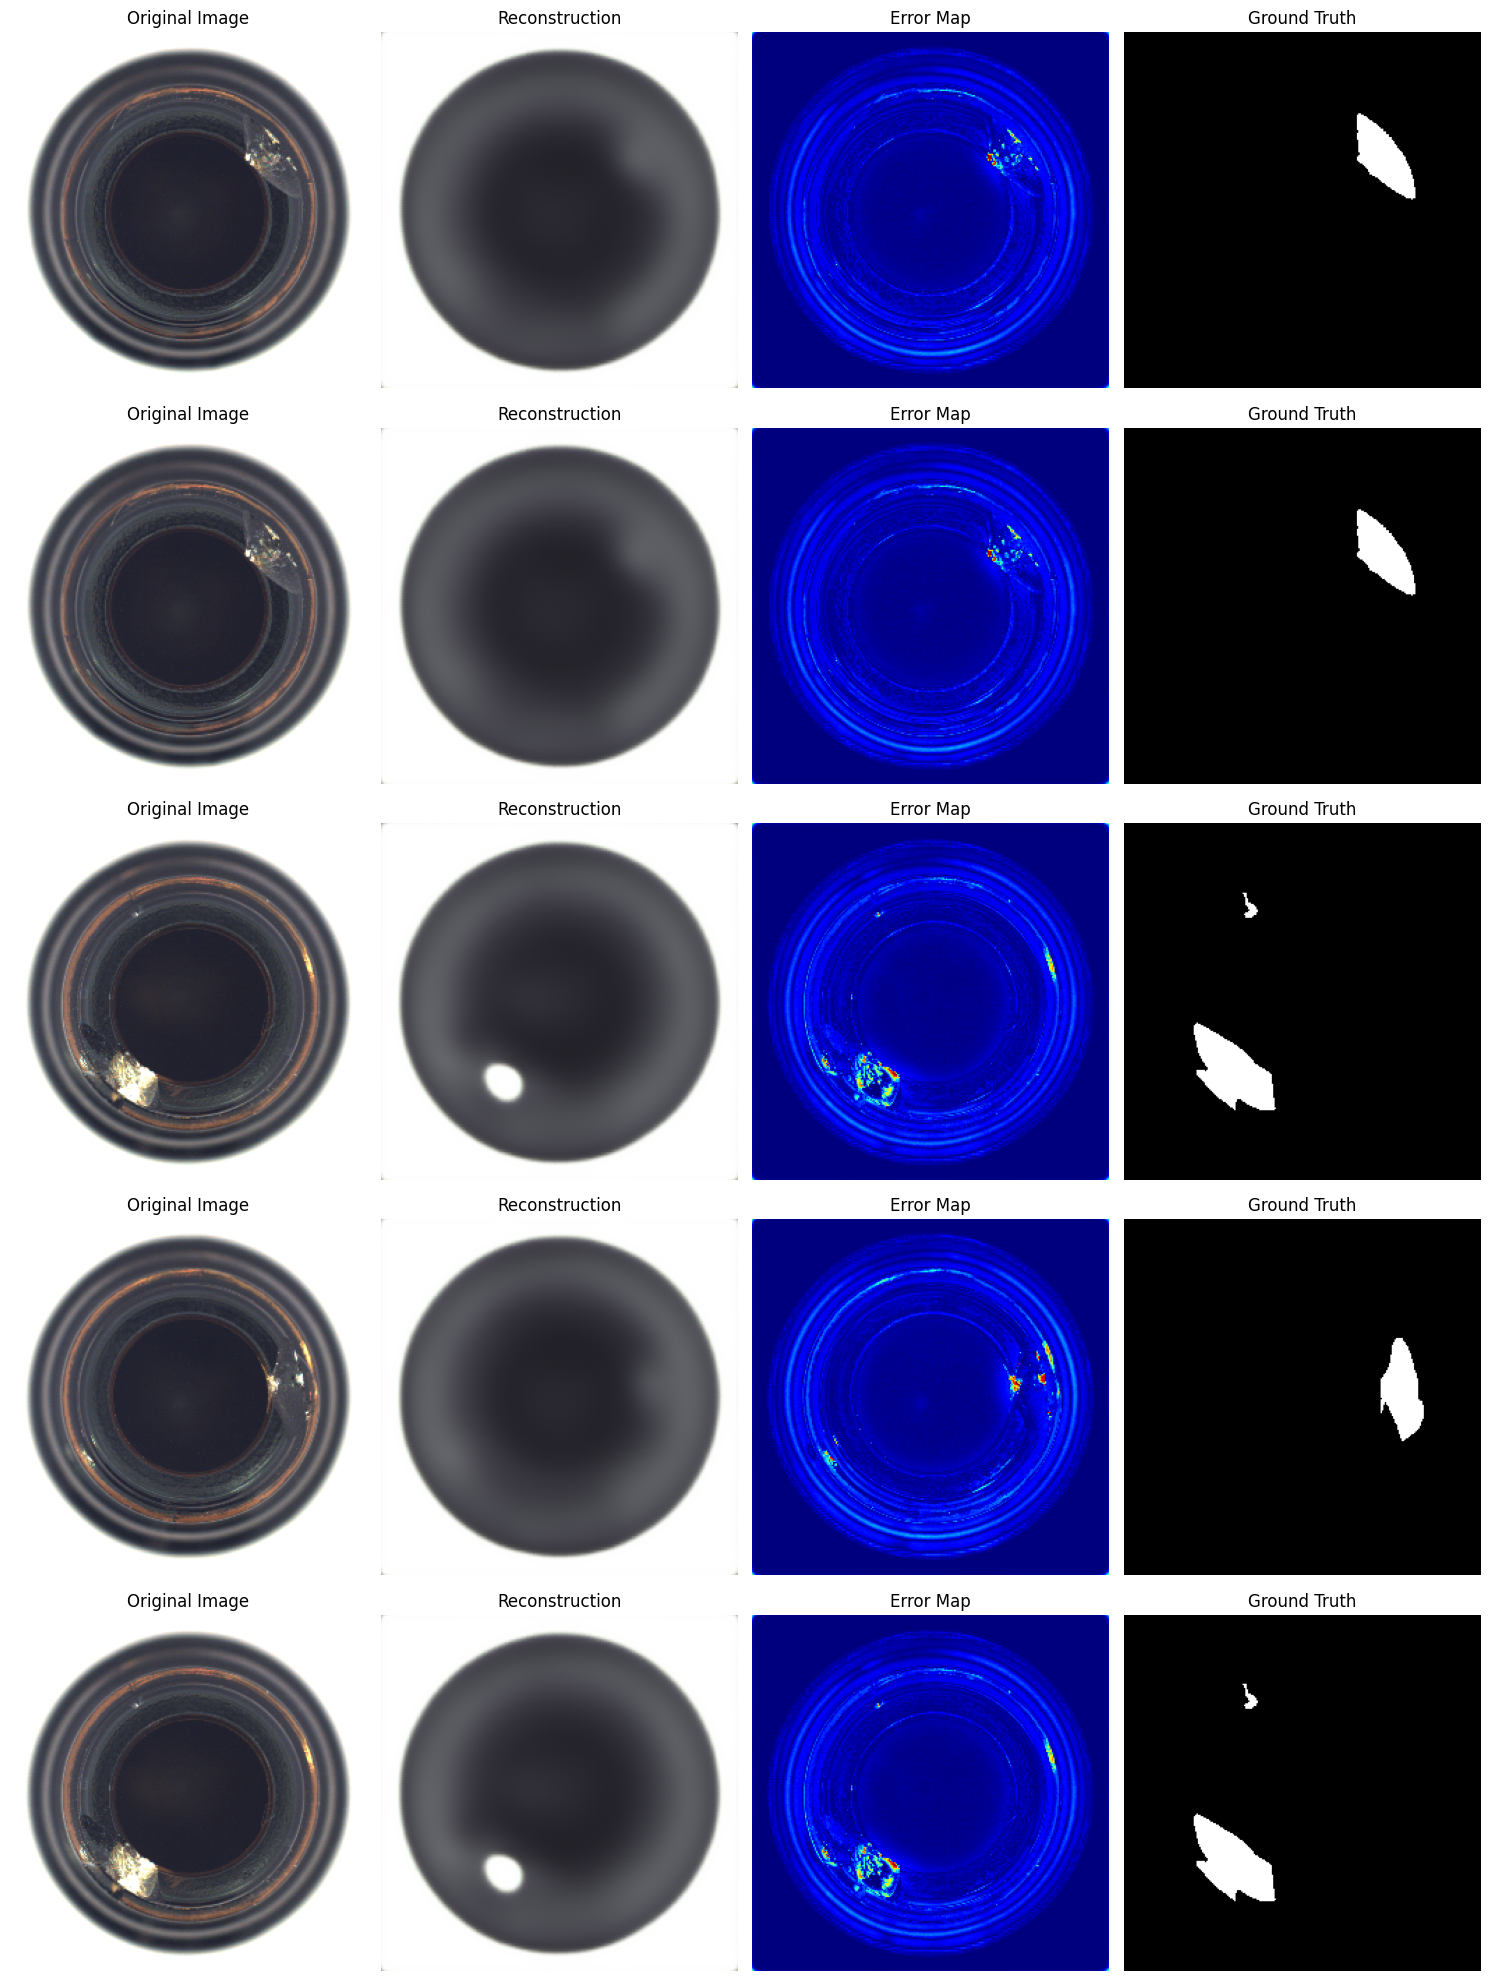

In [16]:
## ======================================
## 4. MVTec-specific Evaluation Metrics
## ======================================

def evaluate_mvtec(model, test_images, test_masks):
    """Compute MVTec metrics: AUROC and PRO"""
    # Get reconstructions and error maps
    reconstructions = model.predict(test_images)
    error_maps = np.mean(np.abs(test_images - reconstructions), axis=-1)

    # Flatten masks and error maps
    # Need to convert test_masks to numpy to flatten
    flat_masks = test_masks.numpy().reshape(-1)
    flat_errors = error_maps.reshape(-1)

    # Compute image-level AUROC
    img_level_scores = np.max(error_maps, axis=(1, 2))
    # Need to convert test_masks to numpy for numpy max
    img_level_labels = np.max(test_masks.numpy(), axis=(1, 2, 3))
    img_auroc = roc_auc_score(img_level_labels, img_level_scores)

    # Compute pixel-level AUROC
    pixel_auroc = roc_auc_score(flat_masks, flat_errors)

    # Compute PRO (Per-Region Overlap)
    pro_scores = []
    # It is standard practice to calculate PRO over relevant thresholds, typically 100
    # or more thresholds chosen from the distribution of anomaly scores.
    # Using a fixed number of linearly spaced thresholds might not be optimal.
    # A better approach might involve using percentiles of the error map values.
    # However, sticking to the original structure for the fix:
    # Note: np.max(error_maps) might be 0 if there are no detected anomalies,
    # leading to no thresholds. Add a small epsilon or check for max > 0.
    max_error = np.max(error_maps)
    if max_error > 0:
        thresholds = np.linspace(0, max_error, 100) # Using more thresholds for better PRO approximation
    else:
        thresholds = [0] # Handle case with no detected errors

    # Store overlaps for each threshold to calculate the PRO AUC at the end
    overlaps_at_thresholds = []

    for thresh in thresholds:
        binary_maps = (error_maps > thresh).astype(bool) # Use bool directly for morphological ops
        current_threshold_overlaps = []

        for i in range(len(test_masks)):
            # Need to convert test_masks[i] to numpy for sum
            if np.sum(test_masks[i].numpy()) > 0:  # Only consider defective images
                # Apply morphological operations to clean up predictions
                cleaned = morphology.remove_small_objects(
                    morphology.remove_small_holes(
                        binary_maps[i], # Use the boolean binary map directly
                    area_threshold=32),
                min_size=32)

                # Convert test_masks[i] to numpy and squeeze.
                # Then convert to boolean to perform bitwise AND with 'cleaned'.
                mask_np_bool = tf.squeeze(test_masks[i]).numpy().astype(bool)

                # Perform bitwise AND between the boolean arrays
                intersection = np.sum(cleaned & mask_np_bool)
                # Convert test_masks[i] to numpy for sum
                union = np.sum(test_masks[i].numpy())
                current_threshold_overlaps.append(intersection / union if union > 0 else 0)

        # Store the mean overlap for this threshold
        if current_threshold_overlaps: # Check if the list is not empty
             overlaps_at_thresholds.append(np.mean(current_threshold_overlaps))
        else:
             overlaps_at_thresholds.append(0) # Append 0 if no defective images were processed


    # Compute PRO Score by integrating the overlaps_at_thresholds over thresholds.
    # According to standard PRO calculation (e.g., MVTec paper), it's the AUC
    # of the per-region overlap curve against the threshold.
    # Use np.trapz for integration.
    if len(thresholds) > 1:
        pro_score = np.trapz(overlaps_at_thresholds, thresholds) / (thresholds[-1] - thresholds[0])
    elif thresholds[0] == 0 and overlaps_at_thresholds: # Handle case with single threshold 0
        pro_score = overlaps_at_thresholds[0]
    else:
        pro_score = 0 # Handle case with no thresholds or overlaps

    return {
        'image_auroc': img_auroc,
        'pixel_auroc': pixel_auroc,
        'pro_score': pro_score
    }

# Evaluate
metrics = evaluate_mvtec(autoencoder, test_images, test_masks)
print(f"Image-Level AUROC: {metrics['image_auroc']:.4f}")
print(f"Pixel-Level AUROC: {metrics['pixel_auroc']:.4f}")
print(f"PRO Score: {metrics['pro_score']:.4f}")

## ======================================
## 5. Visualization for MVTec Defects
## ======================================

def visualize_mvtec_results(images, masks, reconstructions, num_samples=5):
    """Visualize MVTec test cases with ground truth masks"""
    indices = np.random.choice(len(images), num_samples)

    plt.figure(figsize=(15, 4*num_samples))
    for i, idx in enumerate(indices):
        # Ensure images[idx] is a numpy array before subtraction
        # In this case, test_images is a Tensor, so convert it
        image_np = images[idx].numpy() if isinstance(images[idx], tf.Tensor) else images[idx]
        error_map = np.mean(np.abs(image_np - reconstructions[idx]), axis=-1)

        plt.subplot(num_samples, 4, i*4 + 1)
        # images[idx] might be a TensorFlow Tensor, convert to numpy for plotting
        plt.imshow(image_np)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 2)
        # reconstructions[idx] is already a numpy array from model.predict, no .numpy() needed
        plt.imshow(reconstructions[idx])
        plt.title("Reconstruction")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(error_map, cmap='jet')
        plt.title("Error Map")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 4)
        # Convert tensor to numpy and squeeze for plotting
        # test_masks is a TensorFlow Tensor, so .numpy() is needed here
        plt.imshow(tf.squeeze(masks[idx]).numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some test cases
# model.predict on a TensorFlow Tensor input returns a NumPy array
test_reconstructions = autoencoder.predict(test_images[:20])
visualize_mvtec_results(test_images[:20], test_masks[:20], test_reconstructions)